<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Task 1: Project Overview and Import Libraries

In [4]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

1.14.0


In [5]:
input_img=Input(shape=(256,256,3))
l1=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)
l7=Conv2D(256,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)
encoder=Model(input_img,l7)

In [6]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 128)       0   

## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Task 3: Build the Encoder

In [7]:
input_img=Input(shape=(256,256,3))
l1=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)
l7=Conv2D(256,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)

In [8]:
l8=UpSampling2D()(l7)
l9=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D(128,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l5,l10])
l12=UpSampling2D()(l11)
l13=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D(64,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l14,l2])
decoded=Conv2D(3,(3,3),padding='same',activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder=Model(input_img,decoded)
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [9]:
autoencoder.compile(optimizer='adadelta',los='mean_squared_error')

## Task 4: Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

## Task 5: Create Dataset and Specify Training Routine

In [10]:
def train_batches(just_load_dataset=False):

    batches = 256

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("/Users/suraj/Downloads"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Task 6: Load the Dataset and Pre-trained Model

In [11]:
x_train_n,x_train_down=train_batches(just_load_dataset=True)

In [12]:
autoencoder.load_weights('/Users/suraj/Downloads/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Task 7: Model Predictions and Visualizing the Results

In [17]:
encoder.load_weights('/Users/suraj/Downloads/encoder_weights.hdf5')

In [18]:
encoded_imgs=encoder.predict(x_train_down,10)

ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

In [15]:
encoded_imgs.shape

NameError: name 'encoded_imgs' is not defined

In [14]:
sr1=np.clip(autoencoder.predict(x_train_down),0.0,1.0)

ValueError: When using data tensors as input to a model, you should specify the `steps` argument.

In [15]:
image_index=251 #np.random.randint(0,256)

NameError: name 'x_train' is not defined

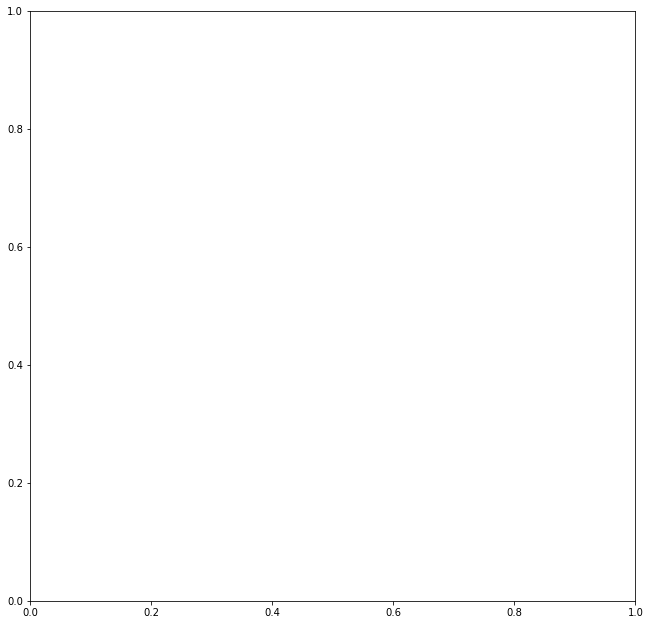

In [16]:
plt.figure(figsize=(128,128))
i=1
ax=plt.subplot(10,10,i)
plt.imshow(x_train[image_index])
i+=1
ax=plt.subplot(10,10,i)
plt.imshow(x_train[image_index],interpolation='bicubic')
i+=1
ax=plt.subplot(10,10,i)
plt.imshow(encoded_imgs[image_index].reshape((64*64,256)))
i+=1
ax=plt.subplot(10,10,i)
plt.imshow(sr1[image_index])
i+=1
ax=plt.subplot(10,10,i)
plt.imshow(x_train_n[image_index])
plt.show()